# Quick Start

# 快速入门

In this comprehensive quick start, we will build a support chatbot in LangGraph that can:

在这个全面的快速入门指南中，我们将构建一个支持聊天机器人，使用LangGraph，它可以：

- Answer common questions by searching the web

- 通过搜索网络回答常见问题
- Maintain conversation state across calls

- 在多次通话中保持对话状态
- Route complex queries to a human for review

将复杂查询转交给人工审查。
- Use custom state to control its behavior

- 使用自定义状态来控制其行为
- Rewind and explore alternative conversation paths

- 倒回并探索替代对话路径

We'll start with a basic chatbot and progressively add more sophisticated capabilities, introducing key LangGraph concepts along the way.

我们将从一个基本的聊天机器人开始，逐步添加更复杂的功能，并在此过程中介绍关键的 LangGraph 概念。

## Setup

## 设置

First, install the required packages:
首先，安装所需的包：


In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

Next, set your API keys:
接下来，设置您的 API 密钥：


In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">

<div class="admonition tip">  
（提示）  
</div>  
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>

<p class="admonition-title">为 LangGraph 开发设置 <a href="https://smith.langchain.com">LangSmith</a></p>
    <p style="padding-top: 5px;">

<p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 

注册 LangSmith，快速发现问题并提升您的 LangGraph 项目的性能。LangSmith 使您能够使用追踪数据来调试、测试和监控使用 LangGraph 构建的 LLM 应用程序——有关如何开始的更多信息，请点击 <a href="https://docs.smith.langchain.com">这里</a>。
    </p>

您的文本似乎只包含一个HTML标签，内容为空。如果您有其他文本需要翻译，请提供相关内容。
</div>
看起来您提供的内容是HTML代码的一部分，包含一个结束标签 `</div>`。这个标签在中文中可以翻译为“结束 div 标签”。如果您需要翻译其他具体的文本，请提供更多内容。


## Part 1: Build a Basic Chatbot

## 第1部分：构建一个基础聊天机器人

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

我们将首先使用 LangGraph 创建一个简单的聊天机器人。这个聊天机器人将直接对用户消息作出回应。虽然简单，但它将展示使用 LangGraph 构建的核心概念。在本节结束时，您将构建一个基本的聊天机器人。

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.
首先创建一个 `StateGraph`。`StateGraph` 对象定义了我们聊天机器人的结构，作为一个“状态机”。我们将添加 `nodes` 来表示聊天机器人可以调用的语言模型（llm）和函数，以及添加 `edges` 来指定机器人在这些函数之间应该如何转换。


In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

<div class="admonition tip">

<div class="admonition tip">  

这段文本的中文翻译为：

<div class="admonition tip">
    <p class="admonition-title">Note</p>

<p class="admonition-title">注意</p>
    <p>

当然可以！但您没有提供要翻译的文本，请提供具体内容，我将为您进行翻译。
    The first thing you do when you define a graph is define the <code>State</code> of the graph. The <code>State</code> consists of the schema of the graph as well as reducer functions which specify how to apply updates to the state. In our example <code>State</code> is a <code>TypedDict</code> with a single key: <code>messages</code>. The <code>messages</code> key is annotated with the <a href="https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages"><code>add_messages</code></a> reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it. State keys without an annotation will be overwritten by each update, storing the most recent value. Check out <a href="https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages">this conceptual guide</a> to learn more about state, reducers and other low-level concepts.

定义图时你要做的第一件事是定义图的 <code>State</code>。<code>State</code> 包含图的架构，以及指定如何将更新应用于状态的 reducer 函数。在我们的示例中，<code>State</code> 是一个具有单个键 <code>messages</code> 的 <code>TypedDict</code>。<code>messages</code> 键使用 <a href="https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages"><code>add_messages</code></a> reducer 函数进行注释，这告诉 LangGraph 将新消息附加到现有列表中，而不是覆盖它。没有注释的状态键将在每次更新时被覆盖，只存储最新值。请查看 <a href="https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages">这个概念指南</a> 了解有关状态、reducer 及其他低级概念的更多信息。
    </p>

这段文本似乎是一个HTML标签，表示段落结束。它本身没有具体的含义。如果你需要翻译其他内容，请提供更完整的文本。
</div>
看起来您提供的文本是一个 HTML 标签，具体是 `</div>`，这个标签通常表示一个“div”元素的结束。用中文来讲，它可以简单理解为“结束一个容器”。如果您有其他文本需要翻译，请提供更多信息！


So now our graph knows two things:

所以现在我们的图知道了两件事：

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.

我们定义的每个 `node` 都将接收当前的 `State` 作为输入，并返回一个更新该状态的值。
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

2. `messages` 将被 _附加_ 到当前的列表中，而不是直接覆盖。这一点通过预构建的 [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) 函数在 `Annotated` 语法中进行了说明。

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.
接下来，添加一个 "`chatbot`" 节点。节点代表工作单元，通常是常规的 Python 函数。


In [4]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

**注意** `chatbot` 节点函数如何将当前的 `State` 作为输入，并返回一个字典，其中包含一个更新后的 `messages` 列表，键为 "messages"。这是所有 LangGraph 节点函数的基本模式。

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

`State` 中的 `add_messages` 函数将把 llm 的响应消息附加到状态中已有的消息上。

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.
接下来，添加一个“入口”点。这告诉我们的图**每次运行时从哪里开始工作**。


In [5]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**
同样，设定一个 `finish` 点。这指示图 **“每当这个节点被执行时，你可以退出。”**


In [6]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "`compile()`" on the graph builder. This creates a "`CompiledGraph`" we can use invoke on our state.
最后，我们需要能够运行我们的图。为此，调用图构建器上的 "`compile()`"。这将创建一个 "`CompiledGraph`"，我们可以在我们的状态上调用它。


In [7]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.
您可以使用 `get_graph` 方法和其中一种 “绘图” 方法（如 `draw_ascii` 或 `draw_png`）来可视化图形。`draw` 方法各自需要额外的依赖。


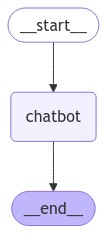

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the chatbot! 

现在让我们启动聊天机器人！

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".
**提示：** 您可以随时通过输入“quit”、“exit”或“q”退出聊天循环。


In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


**Congratulations!** You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a [LangSmith Trace](https://smith.langchain.com/public/7527e308-9502-4894-b347-f34385740d5a/r) for the call above at the provided link.

**恭喜你！** 你已经使用 LangGraph 构建了你的第一个聊天机器人。这个机器人可以通过接受用户输入并使用 LLM 生成回复来进行基本对话。你可以在提供的链接中查看上面的 [LangSmith Trace](https://smith.langchain.com/public/7527e308-9502-4894-b347-f34385740d5a/r)。

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

然而，您可能已经注意到，这个机器人的知识仅限于其训练数据中的内容。在下一部分，我们将添加一个网页搜索工具，以扩展机器人的知识，使其更具能力。

Below is the full code for this section for your reference:

以下是这一部分的完整代码供您参考：

<details>

<details>
<summary>Full Code</summary>

<summary>完整代码</summary>
    <pre>

当然可以！不过你没有提供需要翻译的文本内容。请把需要翻译的文本发给我，我会帮你翻译成中文。
        
```python

请提供您希望翻译的文本内容。
from typing import Annotated

从类型提示导入：注解

from langchain_anthropic import ChatAnthropic

来自 langchain_anthropic 的 ChatAnthropic
from typing_extensions import TypedDict

从 typing_extensions 导入 TypedDict

from langgraph.graph import StateGraph

来自 langgraph.graph 的 StateGraph
from langgraph.graph.message import add_messages

来自 langgraph.graph.message 的 add_messages


class State(TypedDict):

类 State(TypedDict):
    messages: Annotated[list, add_messages]

消息：注释[列表，添加消息]


graph_builder = StateGraph(State)

图形构建器 = 状态图(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):

```python
def 聊天机器人(状态: 状态):
```
    return {"messages": [llm.invoke(state["messages"])]}

返回 {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name

第一个参数是唯一的节点名称。
# The second argument is the function or object that will be called whenever

第二个参数是将在每次调用时使用的函数或对象。
# the node is used.

# 节点正在被使用。
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_node("聊天机器人", chatbot)
graph_builder.set_entry_point("chatbot")

graph_builder.set_entry_point("chatbot") 的中文翻译是：图表构建器设置入口点为“聊天机器人”。
graph_builder.set_finish_point("chatbot")

graph_builder.set_finish_point("聊天机器人")
graph = graph_builder.compile()

图形 = 图形构建器编译()
```

当然，请提供您希望翻译的文本。

</pre>

看起来你提供的文本是一个 HTML 标签，不包含可翻译的内容。如果你有其他具体文本或者内容需要翻译，请提供，我会很乐意帮忙！
</details>
抱歉，您提供的文本 "<\/details>" 是一个HTML标签，翻译成中文是“细节”或“详细信息”。如果您需要翻译更多内容，请提供完整的文本。
